In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Paths & URLs

import os

# Enable CUDA stacktrace reporting for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Directorio base
#PATH_BASE = '/content/drive/MyDrive/proximity'
#PATH_BASE = 'C:\\Users\\User\\Documents\\Proyecto Proximity'
PATH_BASE = 'E:\\files\\Documents\\Proyecto Proximity'

# Data release actual
DR70_PATH = os.path.join(PATH_BASE, 'DR70')
DR70_CT_PATH = os.path.join(DR70_PATH, 'datalake_sorted')
DR70_LABELS_PATH = os.path.join(DR70_PATH, 'labels.csv')

# Data release 176
DR176_PATH = os.path.join(PATH_BASE, 'DR176')
DR176_CT_PATH = os.path.join(DR176_PATH, 'DR176_studies')
DR176_LABELS_PATH = os.path.join(PATH_BASE, 'reports_with_label.csv')


# Data release 217
DR217_PATH = os.path.join(PATH_BASE, 'DR217')
DR217_CT_PATH = os.path.join(DR217_PATH, 'DR217_studies')
DR217_LABELS_PATH = os.path.join(DR217_PATH, 'DR217_labels.csv')
# Used for normalization of the intensity values for each CT
DR217_CT_HISTOGRAM_LANDMARKS_PATH = os.path.join(DR217_PATH, 'DR217_histogram_landmarks.npy')
# Embeddings ResNet18 DR217
DR217_RESNET_EMBEDDINGS_PATH = os.path.join(DR217_PATH, 'DR217_resnet18_embeddings')

# Synth dataset v1
SYNTH_DATASET_V1_PATH = os.path.join(PATH_BASE, 'Synth dataset v1', 'v1', 'npz')

# CTs in Nibabel format
CT_NIBABEL_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs')

# Embeddings visuales de CTs
#CT_EMBEDDINGS_PATH = DATA_RELEASE_PATH + '/visual_embeddings'


# Etiquetas de los CTs del data release actual
#CT_LABELS_CSV_PATH = DATA_RELEASE_PATH + '/labels.csv'

# Data release (CTs + etiquetas) organizados en un DataFrame
#CT_DATASET_DF_HDF_PATH = os.path.join(PATH_BASE, 'dataset_df.h5')
#CT_DATASET_DF_PICKLE_PATH = os.path.join(PATH_BASE, 'dataset_df.pickle')

# URLs de modelos visuales
#RESNET18_URL = 'microsoft/resnet-18'

# Path que contiene los resnet50 embeddings de CTs del data release actual
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18')
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'reshaped_averaged')

# Path de modelos entrenados en base a tripletas
TRIPLET_MODELS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets')
TRIPLET_CHECKPOINTS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets', 'checkpoints')

# Path de modelos entrenados con clasificacion
CLASSIFICATION_MODELS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'clasification')
CLASSIFICATION_CHECKPOINTS_PATH = os.path.join(CLASSIFICATION_MODELS_PATH, 'checkpoints')

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#proximity_vector_labels = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], [1,0,1], [1,1,0], [0,1,1], [1,1,1]]
proximity_vector_labels = [[1,0,0], [0,1,0], [0,0,1]]
#proximity_classes = ['(s/a)', 'c', 'n', 'q', 'c+n', 'c+q', 'n+q', 'c+n+q']
proximity_classes = ['Cube', 'Sphere', 'Tetra']
#proximity_colors = ['#000000', '#ff0000', '#00ff00', '#0000ff',
#              '#ff00ff', '#ffff00', '#00ffff', '#ffffff']
proximity_colors = ['#ff0000', '#00ff00', '#0000ff']

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.set_facecolor('#D1D1D1')
    xlim = (embeddings[:, 0].min(), embeddings[:, 0].max())
    xradius = (xlim[1] - xlim[0]) / 2
    xcenter = xlim[0] + xradius
    xlim = (xcenter - 1.1*xradius, xcenter + 1.1*xradius)
    ylim = (embeddings[:, 1].min(), embeddings[:, 1].max())
    yradius = (ylim[1] - ylim[0]) / 2
    ycenter = ylim[0] + yradius
    ylim = (ycenter - 1.1*yradius, ycenter + 1.1*yradius)
    for i in range(len(proximity_vector_labels)):
        #inds = np.where(targets==i)[0]
        new_mask = [(t == proximity_vector_labels[i]).all() for t in targets]
        #plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
        #embeddings_x = (embeddings[new_mask,0] - embeddings[new_mask,0].min()) / (embeddings[new_mask,0].max() - embeddings[new_mask,0].min())
        #embeddings_y = (embeddings[new_mask,1] - embeddings[new_mask,1].min()) / (embeddings[new_mask,1].max() - embeddings[new_mask,1].min())
        #plt.scatter(embeddings_x, embeddings_y, alpha=0.5, edgecolors=proximity_colors[i], color=proximity_colors[i])
        plt.scatter(embeddings[new_mask,0], embeddings[new_mask,1], alpha=0.6, edgecolors=proximity_colors[i], color=proximity_colors[i])
        
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(proximity_classes)
    plt.show()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros((len(dataloader.dataset), 3))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model(images).data.cpu().numpy()
            labels[k:k+len(images)] = target
            k += len(images)
            #break
    print(embeddings)
    print(labels)
    return embeddings, labels

# Experimento 2: Entrenamiento por tripletas sobre dataset de volúmenes de tres clases

Objetivo: detección de esferas ó cubos ó tetrahedros en el volumen de entrada---Las clases son excluyentes

In [4]:
from datasets import SynthVolumeDataset, BalancedBatchSampler
import torch
from torchvision.transforms import v2
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import default_collate

from trainer import fit
import numpy as np

import random
from pathlib import Path

cuda = torch.cuda.is_available()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Set up data loaders
training_split_ratio = 0.8

volumes_path_list = sorted(Path(SYNTH_DATASET_V1_PATH).glob('*.npz'))

num_subjects = len(volumes_path_list)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_data = (num_training_subjects, num_validation_subjects)

training_data_paths, validation_data_paths = torch.utils.data.random_split(volumes_path_list, num_split_data)

transforms_composite = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((100, 100)),
    v2.ToDtype(torch.float32, scale=True), # with scale=True, scales pixel values from [0, 255] to [0.0, 1.0]
    v2.Normalize(mean=[0.449], std=[0.226])
])

#triplet_training_set = SynthVolumeDataset(training_data_paths, transforms=transforms_composite, train=True)
#triplet_validation_set = SynthVolumeDataset(validation_data_paths, transforms=transforms_composite, train=False)
triplet_training_set = SynthVolumeDataset(training_data_paths, preprocessed=True, train=True)
triplet_validation_set = SynthVolumeDataset(validation_data_paths, preprocessed=True, train=False)

print('Training set size:', len(triplet_training_set))
print('Validation set size:', len(triplet_validation_set))

def collate(batch):
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)


# balanced batch sampler: batch size is n_classes*n_samples. Each batch contains n_samples samples for n_classes randomly selected classes.
train_batch_sampler = BalancedBatchSampler(triplet_training_set.labels_as_classes, n_classes=2, n_samples=4)
test_batch_sampler = BalancedBatchSampler(triplet_validation_set.labels_as_classes, n_classes=2, n_samples=4)


# Set up data loaders
n_classes = 2
batch_size = 8
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_training_set, batch_sampler=train_batch_sampler, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_validation_set, batch_sampler=test_batch_sampler, **kwargs)



# Set up the network and training parameters
from networks import SynthDataEmbeddingModel
from losses import OnlineTripletLoss
from utils import HardestNegativeTripletSelector
from metrics import AverageNonzeroTripletsMetric

margin = 0.2
embedding_net = SynthDataEmbeddingModel(embedding_size=2)
model = embedding_net
if cuda:
    model.cuda()
    
loss_fn = OnlineTripletLoss(margin, HardestNegativeTripletSelector(margin))
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 50, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 1

Training set size: 246
Validation set size: 54


In [5]:
print(model)

SynthDataEmbeddingModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [6]:
fit(
    triplet_train_loader, 
    triplet_test_loader, 
    model, 
    loss_fn, 
    optimizer, 
    scheduler, 
    n_epochs, 
    cuda, 
    log_interval,
    TRIPLET_CHECKPOINTS_PATH,
    metrics=[AverageNonzeroTripletsMetric()]
)

  0%|          | 0/50 [00:00<?, ?it/s]


### EPOCH 1 START ###

### TRAINING LOSS ###
OnlineTripletLoss.forward()
embeddings:
tensor([[-0.0046, -0.0158],
        [-0.0142, -0.0140],
        [-0.0032, -0.0382],
        [-0.0224, -0.0206],
        [-0.0134, -0.0187],
        [-0.0258, -0.0063],
        [ 0.0012, -0.0180],
        [-0.0444, -0.0108]], device='cuda:0', grad_fn=<MmBackward0>)
target:
tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]], device='cuda:0')
FunctionNegativeTripletSelector.get_triplets()
distance_matrix:
tensor([[1.0000, 0.8733, 0.9800, 0.8554, 0.9428, 0.4998, 0.9384, 0.5001],
        [0.8733, 1.0000, 0.7587, 0.9994, 0.9858, 0.8585, 0.6512, 0.8587],
        [0.9800, 0.7587, 1.0000, 0.7352, 0.8575, 0.3173, 0.9884, 0.3176],
        [0.8554, 0.9994, 0.7352, 1.0000, 0.9792, 0.8761, 0.6238, 0.8763],
        [0.9428, 0.9858, 0.8575, 0.9792, 1.0000, 0.7600, 0.7695, 0.7602],
        [0.4998, 0.8585, 0.3173, 0.87

[[-0.24527742 -0.16249505]
 [-0.27895114 -0.18369679]
 [-0.2185753  -0.1499349 ]
 [-0.14894572 -0.1123372 ]
 [ 0.32706863 -0.36721739]
 [ 0.59489059 -0.6567173 ]
 [ 0.46765283 -0.52309877]
 [ 0.49274552 -0.55010903]
 [ 0.12653938 -0.13576858]
 [ 0.0781152  -0.09330348]
 [ 0.15670918 -0.18036865]
 [ 0.13033111 -0.15190716]
 [ 0.55514884 -0.61510754]
 [ 0.51272398 -0.56493616]
 [ 0.3141503  -0.35331845]
 [ 0.4891074  -0.53442991]
 [ 0.57019818 -0.62938792]
 [ 0.39325541 -0.43113813]
 [ 0.38493878 -0.41902977]
 [ 0.41097051 -0.44772816]
 [-0.31244224 -0.20330693]
 [-0.31131566 -0.20977376]
 [-0.36992738 -0.24532105]
 [-0.28163558 -0.18967126]
 [ 0.48931941 -0.54110998]
 [ 0.46769652 -0.51904416]
 [ 0.57204258 -0.62789822]
 [ 0.39854568 -0.44067907]
 [ 0.13159966 -0.15107872]
 [ 0.14306591 -0.16308346]
 [ 0.11300905 -0.12775876]
 [ 0.126507   -0.1327242 ]
 [ 0.09986563 -0.10771193]
 [ 0.06296188 -0.08084857]
 [ 0.11538905 -0.13256018]
 [ 0.16968946 -0.18829119]
 [ 0.47824872 -0.52975142]
 

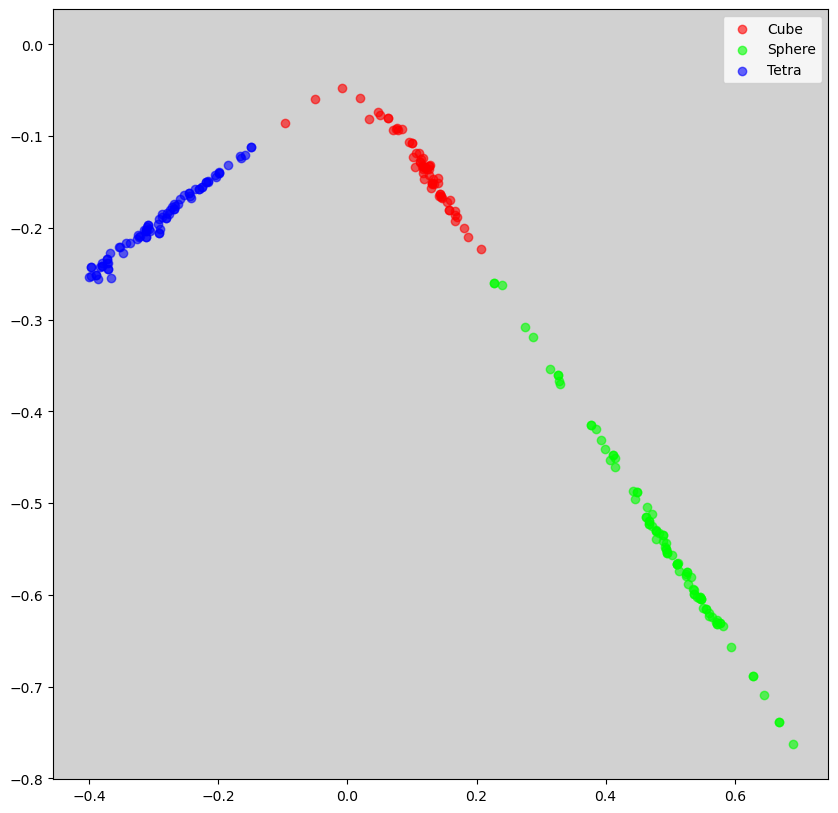

[[ 0.16377909 -0.19373335]
 [ 0.11236054 -0.12360211]
 [ 0.09762284 -0.11424012]
 [ 0.1620097  -0.17394201]
 [-0.30864641 -0.21941058]
 [-0.28873968 -0.19058517]
 [-0.38716114 -0.25214702]
 [-0.37139216 -0.25414225]
 [-0.17619556 -0.13001575]
 [-0.23507893 -0.16504838]
 [-0.32657039 -0.20925862]
 [-0.25525334 -0.16418387]
 [ 0.09403166 -0.10320362]
 [ 0.09762284 -0.11424012]
 [ 0.18238595 -0.21310848]
 [ 0.07595146 -0.1073506 ]
 [-0.30864641 -0.21941058]
 [-0.29959953 -0.19327527]
 [-0.28357795 -0.18700312]
 [-0.38716114 -0.25214702]
 [ 0.5353294  -0.58558559]
 [ 0.3426128  -0.3904458 ]
 [ 0.60238481 -0.66035467]
 [ 0.4697634  -0.51269066]
 [ 0.01426443 -0.03968546]
 [ 0.11236054 -0.12360211]
 [ 0.14660084 -0.15745851]
 [ 0.16377909 -0.19373335]
 [-0.2598792  -0.17669816]
 [-0.19443287 -0.13582776]
 [-0.17619556 -0.13001575]
 [-0.37139216 -0.25414225]
 [-0.28873968 -0.19058517]
 [-0.25525334 -0.16418387]
 [-0.32657039 -0.20925862]
 [-0.3340058  -0.21428643]
 [ 0.51609153 -0.56846273]
 

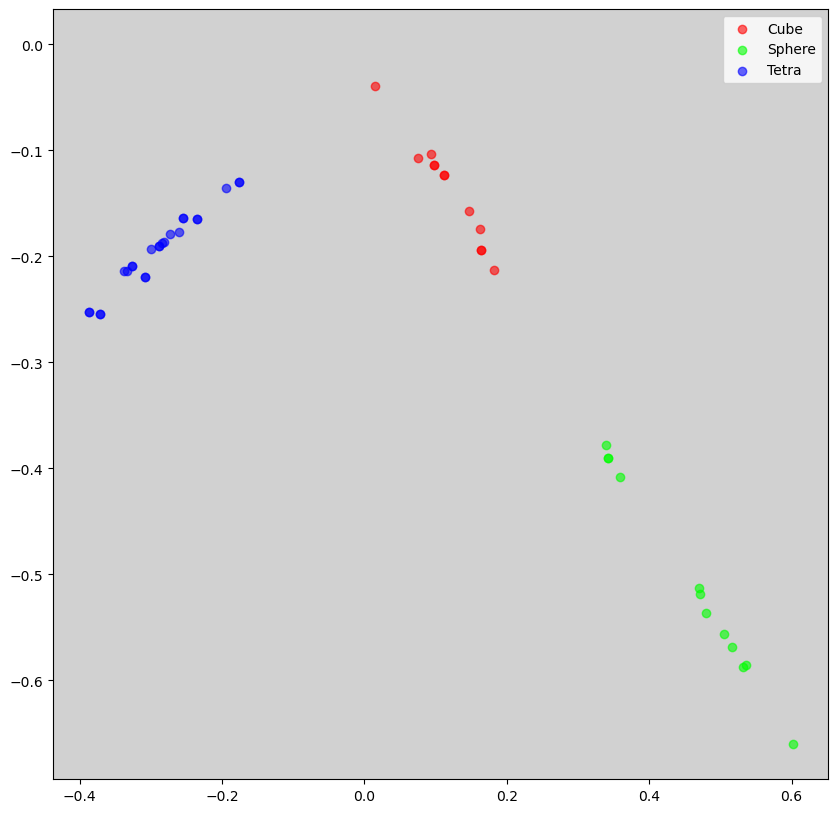

In [7]:
train_embeddings_tl, train_labels_tl = extract_embeddings(triplet_train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(triplet_test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

[[ 0.07231652 -0.0868185 ]
 [ 0.13201541 -0.14490746]
 [ 0.14792281 -0.16309457]
 [ 0.09812565 -0.1070753 ]
 [ 0.54447949 -0.60344237]
 [ 0.56010091 -0.62289965]
 [ 0.3141503  -0.35331845]
 [ 0.43038952 -0.48096293]
 [ 0.41411406 -0.46051583]
 [ 0.45076928 -0.49265426]
 [ 0.49525344 -0.55080491]
 [ 0.50288069 -0.55693442]
 [-0.28043953 -0.18679914]
 [-0.36816716 -0.24837364]
 [-0.29464629 -0.18926439]
 [-0.40053493 -0.25509501]
 [-0.28235123 -0.18496925]
 [-0.1692524  -0.12472929]
 [-0.16695309 -0.12142115]
 [-0.19628419 -0.13712473]
 [ 0.0781152  -0.09330348]
 [ 0.13033111 -0.15190716]
 [ 0.06808254 -0.08468141]
 [ 0.09029447 -0.10137349]
 [ 0.57019818 -0.62938792]
 [ 0.59489059 -0.6567173 ]
 [ 0.32955301 -0.3780337 ]
 [ 0.61339462 -0.66996932]
 [ 0.13960654 -0.15160277]
 [ 0.11323664 -0.12553026]
 [ 0.16968946 -0.18829119]
 [ 0.10497114 -0.10940886]
 [-0.33810443 -0.21383864]
 [-0.27895114 -0.18369679]
 [-0.37407178 -0.25346866]
 [-0.26552856 -0.17909378]
 [ 0.13320369 -0.13612613]
 

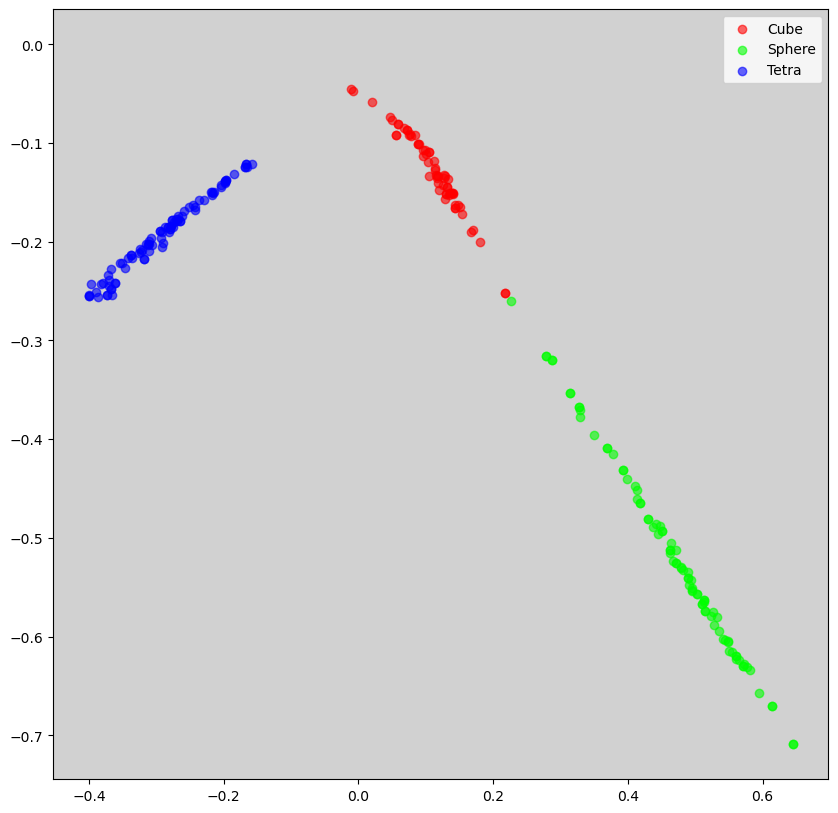

[[ 0.35302448 -0.39073077]
 [ 0.55182612 -0.60110807]
 [ 0.5353294  -0.58558559]
 [ 0.52625966 -0.57464397]
 [-0.30864641 -0.21941058]
 [-0.27308452 -0.17862917]
 [-0.17619556 -0.13001575]
 [-0.28193551 -0.18660167]
 [-0.3340058  -0.21428643]
 [-0.28609854 -0.1895043 ]
 [-0.23507893 -0.16504838]
 [-0.38716114 -0.25214702]
 [ 0.14160888 -0.16376927]
 [ 0.1620097  -0.17394201]
 [ 0.12626399 -0.14117748]
 [ 0.02924324 -0.07217231]
 [-0.3373993  -0.21406843]
 [-0.29959953 -0.19327527]
 [-0.2598792  -0.17669816]
 [-0.28357795 -0.18700312]
 [ 0.53657955 -0.58357143]
 [ 0.54845512 -0.61234808]
 [ 0.4697634  -0.51269066]
 [ 0.576756   -0.63348776]
 [ 0.54845512 -0.61234808]
 [ 0.50519663 -0.55670875]
 [ 0.53657955 -0.58357143]
 [ 0.4697634  -0.51269066]
 [-0.28873968 -0.19058517]
 [-0.19443287 -0.13582776]
 [-0.37139216 -0.25414225]
 [-0.32657039 -0.20925862]
 [-0.28357795 -0.18700312]
 [-0.27308452 -0.17862917]
 [-0.37139216 -0.25414225]
 [-0.25525334 -0.16418387]
 [ 0.11877079 -0.12556599]
 

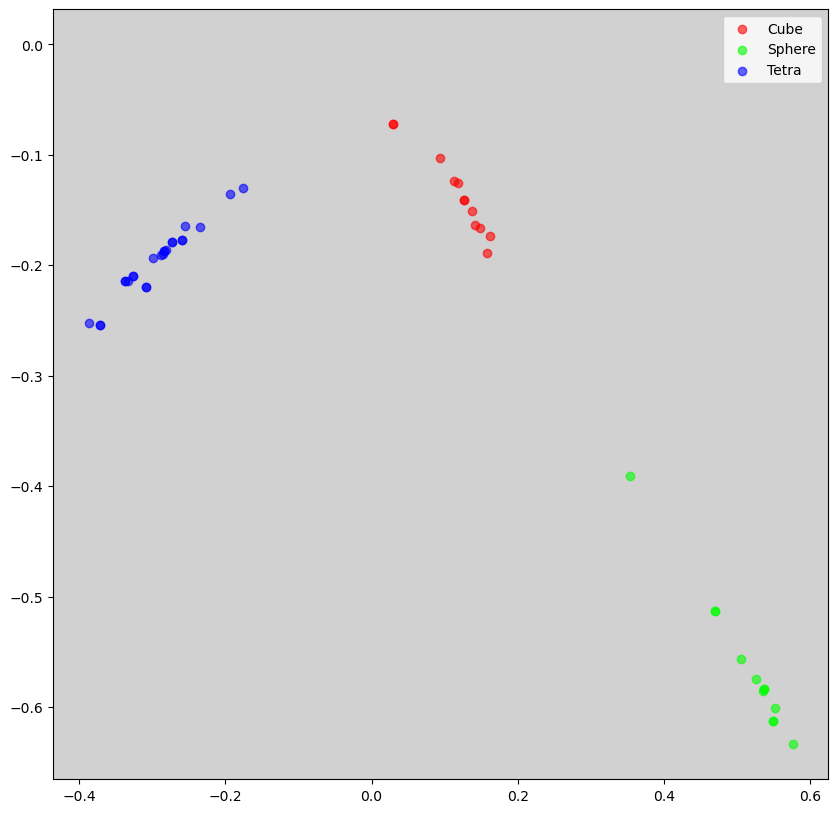

In [8]:
BEST_MODEL_PATH = os.path.join(TRIPLET_CHECKPOINTS_PATH, 'triplets_val-loss_0.0326_20240423_152825.pth')

best_model = SynthDataEmbeddingModel(embedding_size=2).cuda()
best_model.load_state_dict(torch.load(BEST_MODEL_PATH))

train_embeddings_tl, train_labels_tl = extract_embeddings(triplet_train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(triplet_test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)